<a href="https://colab.research.google.com/github/denncraft/Primers/blob/master/%5BTitanic%5D%20Linear_model_and_neural_net_from_scratch_wComments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Этот пример основан на курсе fast.ai и задуман как реальный пример для статьи о градиентном спуске.

В этом блокноте мы будем использовать соревнование Kaggle «Титаник», потому что оно очень маленькое и простое, но в нем также отображено множество сложных реальных проблем, с которыми нам приходится справляться в большинстве практических проектов.

Сначала займемся настройкой. Мы будем загружать данные из Kaggle. Kaggle ищет учетные данные в файле kaggle.json, поэтому нам нужно сначала его создать.

First let's do the setup. We will be downloading data from kaggle. Kaggle is looking for credentials in kaggle.json file, so we need to create it first.

In [1292]:
#!pip install kaggle

import os
from pathlib import Path

#!mkdir ~/.kaggle
#!touch ~/.kaggle/kaggle.json

#api_token = {"username":"","key":""}

import json

#with open('/root/.kaggle/kaggle.json', 'w') as file:
#    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

#import zipfile, kaggle
path = Path('sample_data')

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


Мы собираемся использовать numpy, pytorch и pandas, давайте настроим форматирование, чтобы вывод был читаемым.

In [1293]:
import torch, numpy as np, pandas as pd
# предварительные настройки numpy, шрина вывода = 140 символов
np.set_printoptions(linewidth=180)
# предварительные настройки torch, ширина вывода = 140, (остальные выяснить позже)
torch.set_printoptions(linewidth=180, sci_mode=False, edgeitems=7)
# предварительная настройка вывода pandas на ширину 140 символов... как предсказуемо)
pd.set_option('display.width', 180)

Мы загрузили файл набора данных. Давайте посмотрим на это

In [1294]:
# создаем dataframe pandas, читая данные из файла csv
df = pd.read_csv(path/'train.csv')
# выводим данные dataframe
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


В некоторых записях отсутствуют данные (NaN). Давайте посмотрим, сколько таких у нас, используя метод isna() (is NaN):

In [1295]:
# используя функцию isna() определяем колонки где присутствуют пустые (неизвестные) ячейки (данные) и заодно подсчитываем их количество... для удобства и красоты)
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Многие методы ML плохо работают с отсутствующими данными, это может испортить результаты, давайте заменим их наиболее распространенными значениями. Функция mode() возвращает именно это — наиболее распространенное значение для этого столбца. mode() может возвращать более одного значения (в случае одинакового количества), поэтому давайте возьмем первый элемент, т.е. позиция [0]:

In [1296]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

заменим NaN на полученные на предыдущем этапе наиболее часто повторяющиеся значения

In [1297]:
# в текущем dataframe заполняем все NaN значение fillna() полученными ранее, при этом не создавая нового dataframe
df.fillna(modes, inplace=True)
# проверяем что получилось, по всем колонкам должны быть нули
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Вот как мы получаем краткую сводку всех числовых столбцов в наборе данных:

In [1298]:
import numpy as np
# анализируем данные в dataframe, но только те, что числовые
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Мы видим, что Fare (цена билета) содержит в основном значения от 0 до 30, но есть и несколько действительно больших. Это очень часто встречается в полях, содержащих денежные значения, и это может вызвать проблемы для нашей модели, поскольку, как только этот столбец будет умножен на коэффициент позже, несколько строк с действительно большими значениями будут доминировать в результате.

Наиболее наглядно проблему можно увидеть визуально, взглянув на гистограмму, на которой справа виден длинный хвост:

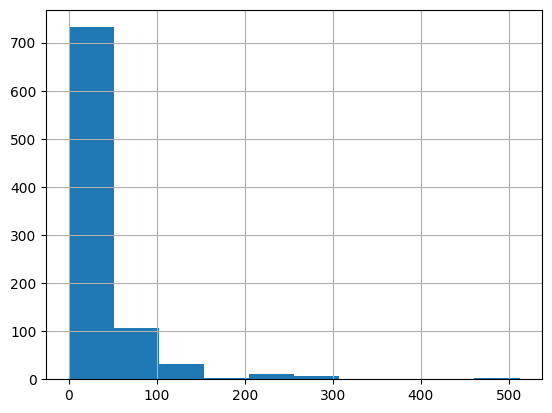

In [1299]:
# показать анализ частоты появления значений в графическом виде
df['Fare'].hist();

Чтобы исправить это, наиболее распространенным подходом является использование логарифма, который сжимает большие числа и делает распределение более разумным. Однако обратите внимание, что в столбце «Тариф» есть нули, а log(0) бесконечен — чтобы это исправить, мы просто сначала добавим 1 ко всем значениям:

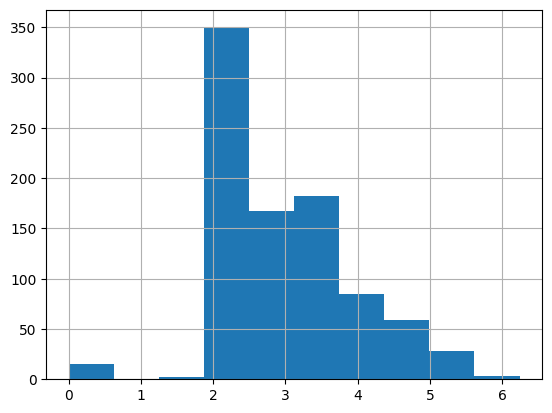

In [1300]:
# создается новая колонка LogFare в которую помещаются изменные данные из колонки Fare
df['LogFare'] = np.log(df['Fare']+1)
# проверка результата
df['LogFare'].hist();

Судя по выводу метода describe(), Pclass содержит всего 3 различных значения, что мы можем подтвердить, просмотрев словарь данных (который вы всегда должны внимательно изучать для любого проекта!)

In [1301]:
# изучаем значения в колонке Pclass, получив только уникальные
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [1302]:
# и как логично было предположить, Survived содержит только 1 или 0, выжил или нет
survives = sorted(df.Survived.unique())
survives

[0, 1]

In [1303]:
# смотрим на все НЕчисловые данные
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In [1304]:
df.head()
palubs = sorted(df['Cabin'].str.slice(stop=1).unique())
df.Cabin = df.Cabin.str.slice(stop=1)

In [1305]:
# for i in range(len(df.Cabin.values)):
#   s = df.Cabin.values[i]
#   if s in palubs:
#     # df.Cabin.values[i] = np.log(palubs.index(s)+1)
#     df.Cabin.values[i] = palubs.index(s)

<Axes: >

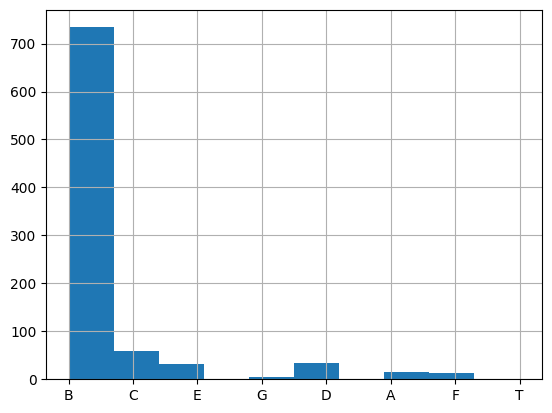

In [1306]:
df.Cabin.hist()

In [1307]:
# embarked_list = sorted(df.Embarked.unique())

In [1308]:
# for i in range(len(df.Embarked.values)):
#   s = df.Embarked.values[i]
#   if s in embarked_list:
#     df.Embarked.values[i] = embarked_list.index(s)
# df.Embarked.hist()

In [1309]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B,S,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C,C,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B,S,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,3.990834
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B,S,2.202765


In [1310]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,LogFare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208,2.962246
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429,0.969048
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400,2.187218
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200,2.737881
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000,3.465736
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,6.240917


Мы не можем работать с нечисловыми значениями. Поэтому нам нужно преобразовать их в числа. Для этого мы создаем dummy-столбцы. Количество dummy-столбцов = количество строковых столбцов, которые требуется заменить * количество уникальных элементов в каждом из запрошенных нечисловых столбцов - 1. Т.е. если в столбце Sex имеется два уникальных значения (male, female), то для этого столбца создадутся два dummy-столбца, а оригинальный будет удален. ДЛя колонки Embarked где 3 уникальных значения, появится 3 новых dummy-столбца, а исходный Embarked будет удален. В dummy-столбцах будут записаны 1 и 0, в зависимости от того, какое значение было в исходных столбцах-строках. Таким образом, это преобразует текстовое значение в числовое значение, хотя и в виде нескольких столбцов.

Pandas может создавать их автоматически с помощью get_dummies, который также удаляет исходные столбцы. Мы создадим фиктивные переменные для Pclass, даже если они числовые, поскольку числа 1, 2 и 3 соответствуют каютам первого, второго и третьего класса, а не числам или показателям, на которые имеет смысл умножать. Мы также создадим фиктивные данные для «Sex, Cabin, Embarked», поскольку мы хотим использовать их в качестве предикторов в нашей модели. С другой стороны Name и Ticket имеют слишком много уникальных значений, да и странно было бы, если бы решение погибнет или нет зависело от имени человека или номера его билета.

In [1311]:
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [1312]:
df.shape[1]

18

Мы видим, что таблица стала шире, если ранее она содержала 12 колонок, то сейчас уже 25, вместо колонки Sex появились Sex_male и Sex_female по одному для каждого из возможных значений столбца Sex, а сама колонка Sex отсутствует, т.к. была удалена. Вместо Cabin появились Cabine_A, Cabine_B, Cabin_C ... Вместо Embarked появилиь новые 3 колонки.

In [1313]:
df.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,LogFare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,B,2.110213,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",38.0,1,0,PC 17599,71.2833,C,4.280593,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,B,2.188856,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C,3.990834,1,0,1,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,B,2.202765,0,1,0,0,1,0,0,1


Ниже можно увидеть как распределились значения по вновь созданным колонкам. В строках где в оригинальной колонке было значение соответствующее имени новой колонки стоят 1, а в остальных строках 0. т.е. если в колонке Sex в строке было male то в новой колонке Sex_male в этой строке будет 1, а там где было female будет 0 И также для новой колонки Sex_female.

In [1314]:
df.columns[10:]

Index(['Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'], dtype='object')

In [1315]:
#added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


Теперь нам нужно создать наши независимые и зависимые переменные (предикторы и цель) в виде тензоров pytorch. Независимые переменные — это те столбцы, которые мы собираемся использовать, чтобы предсказать, выживет ли пассажир. Это возраст, количество братьев и сестер, стоимость проезда и добавленные столбцы.

In [1316]:
from torch import tensor
# создаем тензор на основе значений колонки Survived, в которой содержиться конечный результат.
t_dep = tensor(df.Survived)

# создаем список колонок, который содержит перечень колонок с данными на основе которых будет выполняться предсказывание результата
indep_cols = ['Age', 'SibSp', 'LogFare'] + added_cols
indep_cols

['Age',
 'SibSp',
 'LogFare',
 'Sex_male',
 'Sex_female',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

In [1317]:
# создаем тензор на основе данных из исследуемых столбцов
t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  3.4054,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
      

Посмотрим на размер тензора, ого!: 891 х 19

In [1318]:
t_indep.shape

torch.Size([891, 11])

Теперь мы собираемся вручную выполнить один шаг расчета прогнозов и расчета потерь. Мы инициализируем коэффициенты нашей модели случайными значениями от -0,5 до 0,5. Попробуй выполнить эту операцию получения рандомных чисел несколько раз и все равно будешь получать одни и теже значения: МАГИЯ!

In [1319]:
# определим специальных seed токен, чтобы все расчеты, сколько бы раз мы их не запускали выдавали одни и теже результаты.
torch.manual_seed(442)

# определим размер массива для хранения коэффициентов, он равен количеству исследуемых столбцов, т.е. 19
n_coeff = t_indep.shape[1]
# создаем тензор размером 19 и заполняем его рандомными значениями от 0 до 1, а потом еще вычитаем 0.5, чтобы получить как положительные коэффициенты так и отрицательные
coeffs = torch.rand(n_coeff)-0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103])

Теперь мы рассчитыем наши прогнозы, умножая все столбцы на соответствующие коэффициенты и суммируя их. Эти прогнозы будут случайными, поскольку сначала мы выбираем случайные коэффициенты. Это нормально в качестве первого шага – нам нужно с чего-то начинать!

In [1320]:
# перемножаются два тензора
t_indep*coeffs

tensor([[-10.1838,   0.1386,   0.5084,  -0.2262,  -0.0000,  -0.0000,   0.0000,   0.3136,   0.0000,  -0.0000,   0.2103],
        [-17.5902,   0.1386,   1.0312,  -0.0000,  -0.2632,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000],
        [-12.0354,   0.0000,   0.5273,  -0.0000,  -0.2632,  -0.0000,   0.0000,   0.3136,   0.0000,  -0.0000,   0.2103],
        [-16.2015,   0.1386,   0.9614,  -0.0000,  -0.2632,  -0.3147,   0.0000,   0.0000,   0.0000,  -0.0000,   0.2103],
        [-16.2015,   0.0000,   0.5306,  -0.2262,  -0.0000,  -0.0000,   0.0000,   0.3136,   0.0000,  -0.0000,   0.2103],
        [-11.1096,   0.0000,   0.5413,  -0.2262,  -0.0000,  -0.0000,   0.0000,   0.3136,   0.0000,  -0.4392,   0.0000],
        [-24.9966,   0.0000,   0.9558,  -0.2262,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.0000,  -0.0000,   0.2103],
        ...,
        [-11.5725,   0.0000,   0.5024,  -0.2262,  -0.0000,  -0.0000,   0.0000,   0.3136,   0.0000,  -0.0000,   0.2103],
        [-18.0531,   0.0000

и, как мне сказали значющие люди: у нас здесь Проблема. В суммах каждой строки будет доминировать первый столбец — «Age», поскольку его значения в среднем значительно больше значений в других столбцах. Давайте нормализуем все столбцы так, чтобы они содержали числа от 0 до 1, разделив каждый столбец на его max():

In [1321]:
# интересный результат, все единицы
vals,_ = t_indep.max(dim=0)
vals

tensor([80.0000,  8.0000,  6.2409,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000])

In [1322]:
# делим тензоры для получения нормализованного результата, где значения по всем колонкам и строкам варируются между 0 и 1
t_indep = t_indep / vals
t_indep

tensor([[0.2750, 0.1250, 0.3381, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.6859, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.3507, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.1250, 0.6395, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.0000, 0.3530, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.3600, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.6750, 0.0000, 0.6358, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3125, 0.0000, 0.3342, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4875, 0.0000, 0.5456, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.4229, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000],
       

Подводя промежуточный итог:

In [1323]:
# расчитываем результат предсказания с учетом выбранных коэффициентов.
preds = (t_indep * coeffs).sum(axis=1)
preds[:10]


tensor([ 0.2692, -0.3354,  0.1947, -0.3988,  0.1802, -0.4039, -0.4899,  0.4575,  0.2007,  0.5732])

Как упоминалось в статье выше, для расчета потерь мы берем среднее значение всех различий между прогнозируемыми и фактическими значениями:

In [1324]:
# пробуем рассчитать значение ошибки предсказания
loss = torch.abs(preds - t_dep).mean()
loss

tensor(0.5755)

Чтобы сделать код более читабельным, давайте разложим его по функциям:

In [1325]:
# функция для расчета предсказания, которой передатся тензор с коэффициентами и тензор с данными для анализа
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
# функция для расчета ошибки, которая также получает тензор с коэффициентами, тензор с данными для анализа, но еще и тензор исходных данных
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

Мы собираемся выполнить одну «эпоху» градиентного спуска вручную. Единственное, мы собираемся это автоматизировать, потому что, делать это вручную совершенно бессмысленно! Чтобы PyTorch вычислил градиенты нужно вызвать require_grad_() для наших коэффициентов:

In [1326]:
# установим флаг требования вычислять градиент
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103], requires_grad=True)

In [1327]:
# вычисляем ошибку предсказания
loss = calc_loss(coeffs, t_indep, t_dep)
# Используйте backward(), чтобы PyTorch вычислил градиенты.
loss.backward()
# смотрим градиент спуска
coeffs.grad

tensor([-0.0338,  0.0073, -0.0877,  0.1448, -0.1975, -0.2424,  0.0090,  0.1807, -0.0786, -0.0864,  0.1122])

Обратите внимание, что каждый раз, когда мы вызываем backward(), значения градиентов фактически добавляются к тем, что уже находится в атрибуте .grad. Давайте попробуем выполнить описанные выше шаги еще раз:

In [1328]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.0677,  0.0146, -0.1754,  0.2896, -0.3951, -0.4848,  0.0180,  0.3614, -0.1571, -0.1728,  0.2245])

Как видите, наши значения .grad увеличились вдвое. Это потому, что градиенты были добавлены во второй раз. По причине этого каждый раз, после того как вычисляем градиенты для выполнения шага градиентного спуска, нам необходимо их обнулять.

 Обратите внимание, что x.sub_(y) вычитает y из x in-place. В PyTorch любой метод, заканчивающийся на _ , изменяет свой объект на месте. Аналогично, x.zero_() устанавливает все элементы тензора x в ноль.

In [1329]:
# вычисляем ошибку предсказания
loss = calc_loss(coeffs, t_indep, t_dep)
# вычисляем градиент
loss.backward()
loss

tensor(0.5755, grad_fn=<MeanBackward0>)

In [1330]:
# В этом режиме результат каждого вычисления будет иметь require_grad=False
# контекстный менеджер, запрещающий расчет градиента, чтобы сэкономить память и вычислительные ресурсы
with torch.no_grad():
    # изменяем коэффициенты чтобы уменьшить ошибку, вычитая из коэффициента уменьшенное в 10 раз значение его градиента
    coeffs.sub_(coeffs.grad * 0.1)
    # обнуляем градиент
    coeffs.grad.zero_()
    # заново выполняем предсказание и вычисляем ошибку
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5207)


Чтобы обучить нашу модель и улучшить коэффициенты, нам нужны данные для обучения и данные для последующей валидации. У нас все данные в одном фрагменте, поэтому давайте воспользуемся RandomSplitter для получения индексов, которые разделят наши данные на наборы обучения и проверки и создадут оба набора:

In [1171]:
from fastai.data.transforms import RandomSplitter
# метод RandomSplitter принимает на вход значение valid_pct, это делитель по-умолчанию 0.2, т.е. разделение будет 80/20
# также метод принимает параметр seed, для повторяемости результатов, по умолчанию = NULL
# возвращает два список индексов переданного на вход набора данных, разделенных в соответствии со значением valid_pct
train_split, validation_split=RandomSplitter(valid_pct=.15, seed=42)(df) #original seed = 42

# создаем отдельные тензоры для тренировочных и проверочных данных
trn_indep = t_indep[train_split]
val_indep = t_indep[validation_split]
# для данных с результатами тоже
trn_dep   = t_dep[train_split]
val_dep   = t_dep[validation_split]
len(trn_indep), len(val_indep)

(758, 133)

In [1172]:
t_indep

tensor([[0.2750, 0.1250, 0.3381, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4750, 0.1250, 0.6859, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.3250, 0.0000, 0.3507, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.1250, 0.6395, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.4375, 0.0000, 0.3530, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.3000, 0.0000, 0.3600, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.6750, 0.0000, 0.6358, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        ...,
        [0.3125, 0.0000, 0.3342, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.4875, 0.0000, 0.5456, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000],
        [0.3375, 0.0000, 0.4229, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000],
       

Создадим три функции, которые мы уже описали выше: инициализация коэффициентов случайными числами, выполнение одного полного шага градиентного спуска и обновление коэффициентов.

In [1331]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
      one_epoch(coeffs, lr=lr)
    return coeffs

In [1174]:
# функции для теста
def one_epoch2(coeffs, n_epoch, min_loss, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    if loss < min_loss:
      print(f"{loss:.8f} {n_epoch}", end="; ")

# функции для теста
def init_coeffs2(): return (torch.tensor([-0.0010, -0.0021,  0.0010, -0.5266,  0.4723,  0.3078,  0.3077,  0.3076,  0.1994,  0.1992,  0.1992,  0.1996,  0.1999,  0.1993, -0.3547,  0.0555,  0.0207,  0.0207,  0.0208]).requires_grad_())

# функция для теста
# для запуска модели указыавется количество эпох\циклов обучения и
# скорость обучения (подбираются экспериментально)
def train_model2(epochs=30, lr=0.1, min_loss=0.999):
    torch.manual_seed(442)
    # определяем начальные рандомные коэффициенты
    coeffs = init_coeffs()
    # каждая эпоха производит вычисление предсказания, его ошибку,
    # градиент спуска и изменение коэффициентов по результатам градиентного спуска
    for i in range(epochs):
      one_epoch(coeffs, i, lr=lr, min_loss=min_loss)
    # по окончании выполнения всех эпох возвращается тензор с итоговыми коэффициентами
    return coeffs

lr отвечает за скорость обучения, читайте об этом здесь
https://medium.com/innova-technology/gradient-descent-complete-explanation-495ec75fee7b: если сможете открыть

Давайте потренируем модель.

In [1332]:
coeffs = train_model(lr=0.2)
coeffs

0.556; 0.532; 0.509; 0.493; 0.483; 0.479; 0.475; 0.471; 0.468; 0.464; 0.461; 0.457; 0.454; 0.450; 0.447; 0.444; 0.441; 0.438; 0.435; 0.432; 0.430; 0.427; 0.425; 0.422; 0.420; 0.418; 0.416; 0.414; 0.412; 0.411; 

tensor([-0.2724,  0.1008,  0.2877, -0.1928, -0.2192,  0.1279,  0.2380,  0.1979,  0.1307, -0.0187,  0.0164], requires_grad=True)

Наши потери печатаются в конце каждого шага, и они уменьшаются! Это работает!

А теперь давайте посмотрим на коэффициенты для каждого столбца:

In [1176]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.2323),
 'SibSp': tensor(0.0373),
 'LogFare': tensor(0.4375),
 'Sex_male': tensor(-0.4557),
 'Sex_female': tensor(0.3299),
 'Pclass_1': tensor(0.2652),
 'Pclass_2': tensor(0.2992),
 'Pclass_3': tensor(0.2856),
 'Embarked_C': tensor(0.2382),
 'Embarked_Q': tensor(-0.0592),
 'Embarked_S': tensor(0.2356)}

# **Точность измерения**

---



Соревнования Kaggle оцениваются по точности, а не по результату (проигрышу). Точность — это доля строк, в которых мы правильно предсказываем выживание. Давайте посмотрим, насколько точны мы были на проверочном наборе. Сначала рассчитаем прогнозы и предположим, что значение выше 0,7 предсказывает выживание:

In [1177]:
# предскажем результат (выживет или нет) пассажир из списка отобранных для валидации строк
preds = calc_preds(coeffs, val_indep)
preds

tensor([ 0.6819, -0.1470,  0.1462,  0.3291,  0.1916,  0.2018,  1.0291,  0.9684,  0.3572,  1.0096,  0.1261,  0.1985,  0.2335,  0.6397,  0.1080,  0.1470,  0.0889,  1.0232,  0.1970,
         0.9203,  0.1491,  0.1150,  1.0555,  1.0237,  0.1537, -0.0683,  1.0279,  0.0976,  0.1752,  0.6387,  0.9975,  1.0992,  0.1636,  0.1314,  0.6645,  1.1075,  0.1580,  1.0618,
         0.1503,  0.9366,  0.1952,  0.1503,  0.2042,  1.0452,  0.1619,  0.9919,  0.2741,  0.2348, -0.1537,  0.9352, -0.0519,  0.3340,  0.3019,  0.1391,  0.1749,  0.1574, -0.1469,
         0.1624,  0.1590,  0.1818,  0.1961,  0.1671,  0.0536,  0.1580,  0.9727,  0.2899,  0.1945,  0.1784, -0.1443,  0.9215,  0.1432,  0.9794,  0.1603,  0.1607,  0.2063,  0.1713,
         0.1503,  0.2557,  0.2090,  0.1370,  0.3442,  1.1724,  0.1520,  0.1438,  0.8908,  0.2768,  0.3296,  1.1310,  1.0163,  0.1974,  0.1294,  0.1503,  1.0741,  0.1287,  1.0718,
         0.1616,  0.1766,  0.7195,  0.6445, -0.1409,  0.1708,  0.6387,  0.1258,  0.1316,  0.2445,  0.1422

In [1178]:
# напомню, что для валидации из общего числа 891 было отобрано 178
preds.shape

torch.Size([133])

In [1179]:
# установим порог значения, который будет говорить, что все значения больше = True, а все, что меньше = False
threshold = 0.7
preds>threshold

tensor([False, False, False, False, False, False,  True,  True, False,  True, False, False, False, False, False, False, False,  True, False,  True, False, False,  True,  True,
        False, False,  True, False, False, False,  True,  True, False, False, False,  True, False,  True, False,  True, False, False, False,  True, False,  True, False, False,
        False,  True, False, False, False, False, False, False, False, False, False, False, False, False, False, False,  True, False, False, False, False,  True, False,  True,
        False, False, False, False, False, False, False, False, False,  True, False, False,  True, False, False,  True,  True, False, False, False,  True, False,  True, False,
        False,  True, False, False, False, False, False, False, False, False, False,  True, False, False,  True,  True, False,  True, False,  True,  True, False, False,  True,
        False, False, False,  True, False, False,  True,  True, False, False,  True, False,  True])

In [1180]:
# напомню, что val_dep содержит значения 1 или 0, указывающие на то, выжил пассажир или нет.
# преобразуем 1 и 0 в True и False
# далее сравним известные знаения с предсказанными моделью, предварительно преобразовав числа
# в True или False относительно значения порога
results = val_dep.bool()==(preds>threshold)
results[:16]

tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False, False,  True, False])

Наша точность — это среднее значение:

In [1181]:
# получим средний процент угаданных значений,
# т.е. где совпали val_dep(True) и preds(True), а также  val_dep(False) и preds(False)
results.float().mean()

tensor(0.7744)

Давайте поместим это в функцию   

In [1334]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>threshold)).float().mean()
acc(coeffs)

tensor(0.6241)

Если внимательно посмотреть на прогнозы, то можно заметить, что часть из них имеет отрицательные вероятности, а часть и вовсе больше единицы, что не имеет смысла и портит нашу модель. Итак, давайте зафиксируем эти значения с помощью функции сигмоиды. Она имеет минимум при нуле и максимум при единице и определяется следующим образом:

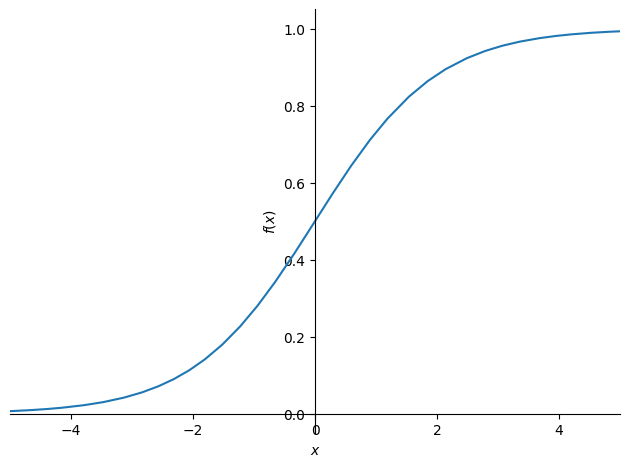

In [1335]:
# графическое представление функции Сигмоиды
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-5,5));

Давайте воспользуемся этим в нашем Calc_preds.

In [1184]:
# перепишем старую функцию расчета предсказания:
# preds = (t_indep * coeffs).sum(axis=1)
# так, чтобы результаты были строго между 0 и 1
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [1185]:
# заново запустим модель обучаться c высокой скоростью обучения
coeffs = train_model(6, lr=100)
acc(coeffs)

0.519; 0.325; 0.269; 0.209; 0.204; 0.202; 

tensor(0.8346)

Как видите, всего за 6 эпох обучения точность предсказания несколько увеличилась и достигла макисмума.

In [1336]:
show_coeffs()

{'Age': tensor(-0.2724),
 'SibSp': tensor(0.1008),
 'LogFare': tensor(0.2877),
 'Sex_male': tensor(-0.1928),
 'Sex_female': tensor(-0.2192),
 'Pclass_1': tensor(0.1279),
 'Pclass_2': tensor(0.2380),
 'Pclass_3': tensor(0.1979),
 'Embarked_C': tensor(0.1307),
 'Embarked_Q': tensor(-0.0187),
 'Embarked_S': tensor(0.0164)}

Эти коэффициенты кажутся разумными: в целом у пожилых людей и мужчин меньше шансов выжить, а у пассажиров первого класса шансов выжить больше.

# **Используя матрицы**


---

Мы можем сделать все немного аккуратнее...

Взгляните на самые ранние вычисления, которые мы делаем, чтобы получить прогнозы:

In [1187]:
(val_indep*coeffs).sum(axis=1)

tensor([  9.5872, -16.4989, -15.4266, -10.5375, -10.8902, -11.0519,   2.4388,   6.4960, -19.2242,   2.0890, -19.6636, -15.3996, -19.1987,   0.9419, -19.7226, -10.0038, -10.3533,
          6.6389, -11.0443,  -2.1964, -19.5243, -10.1960,  11.7744,   6.2933, -19.4681, -16.4200,  -1.7077, -10.3009, -19.3905,   0.9398,   6.6708,  -2.0478, -19.4369, -19.6355,
          9.4823,  -1.7907, -10.0057,  12.0393, -19.5219,  -2.1695, -10.8124, -19.5219, -11.0007,  11.9125, -19.4520,  -2.1733, -19.3021, -19.4134, -16.5119,  -2.0611,  -6.9274,
        -19.3640, -19.3512, -19.5555, -10.9347, -11.0396, -16.4987, -19.7152, -19.4695, -19.5129,  -5.6273, -19.4824, -10.5992, -19.4714,   6.2401,  -9.4404, -10.8727, -19.6432,
        -16.7577,   6.2037, -19.5592,   2.1057, -11.0221, -19.5014,  -9.6399, -19.3863, -19.5219,  -9.7836, -10.7853, -11.2563, -10.4596,  12.1402, -19.5068, -19.5346,   6.0844,
         -6.6953,  -5.2996,   8.1137,  10.6175, -10.8552, -19.6570, -19.5219,  11.9928, -15.5314,   2.4089,  -

это то же самое с помощью другого синтаксиса

In [1188]:
val_indep@coeffs

tensor([  9.5872, -16.4989, -15.4266, -10.5375, -10.8902, -11.0519,   2.4388,   6.4960, -19.2242,   2.0890, -19.6636, -15.3996, -19.1987,   0.9419, -19.7226, -10.0038, -10.3533,
          6.6389, -11.0443,  -2.1964, -19.5243, -10.1960,  11.7744,   6.2933, -19.4681, -16.4200,  -1.7077, -10.3009, -19.3905,   0.9398,   6.6708,  -2.0478, -19.4369, -19.6355,
          9.4823,  -1.7907, -10.0057,  12.0393, -19.5219,  -2.1695, -10.8124, -19.5219, -11.0007,  11.9125, -19.4520,  -2.1733, -19.3021, -19.4134, -16.5119,  -2.0611,  -6.9274,
        -19.3640, -19.3512, -19.5555, -10.9347, -11.0396, -16.4987, -19.7152, -19.4695, -19.5129,  -5.6273, -19.4824, -10.5992, -19.4714,   6.2401,  -9.4404, -10.8727, -19.6432,
        -16.7577,   6.2037, -19.5592,   2.1057, -11.0221, -19.5014,  -9.6399, -19.3863, -19.5219,  -9.7836, -10.7853, -11.2563, -10.4596,  12.1402, -19.5068, -19.5346,   6.0844,
         -6.6953,  -5.2996,   8.1137,  10.6175, -10.8552, -19.6570, -19.5219,  11.9928, -15.5314,   2.4089,  -

А еще оказывается, что так намного быстрее, потому что матричные продукты в PyTorch очень сильно оптимизированы.

Давайте воспользуемся этой возможностью, чтобы изменить функцию Calc_preds:

In [1340]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

In order to do matrix-matrix products (which we'll need in the next section), we need to turn coeffs into a column vector (i.e. a matrix with a single column), which we can do by passing a second argument 1 to torch.rand(), indicating that we want our coefficients to have one column:
Чтобы получить матрично-матричное произведение (которое нам понадобится в следующем разделе), нам нужно преобразовать коэффициенты в вектор-столбец (т. е. матрицу с одним столбцом), что мы можем сделать, передав второй аргумент 1 в torch.rand(), указывающий, что мы хотим, чтобы наши коэффициенты имели один столбец:

In [1190]:
torch.manual_seed(442)
(torch.rand(n_coeff)-0.5).requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103], requires_grad=True)

In [1191]:
torch.manual_seed(442)
init_coeffs()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103], requires_grad=True)

In [1192]:
torch.manual_seed(442)
(torch.rand(n_coeff, 1)-0.5).requires_grad_()

tensor([[-0.4629],
        [ 0.1386],
        [ 0.2409],
        [-0.2262],
        [-0.2632],
        [-0.3147],
        [ 0.4876],
        [ 0.3136],
        [ 0.2799],
        [-0.4392],
        [ 0.2103]], requires_grad=True)

In [1338]:
def init_coeffs(): return (torch.rand(n_coeff, 1)-0.5).requires_grad_()

По той же причине требуется преобразовать переменные со списками результатов в переменную вектор-столбец, что можно сделать, проиндексировав измерение столбца специальным значением None, которое сообщит PyTorc, что нужно добавить новую колонку (измерение) в эту позицию:

In [1194]:
# так выглядело раньше, это горизонтальный список, а надо чтобы была матрица со значениями в колонке
trn_dep

tensor([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0

In [1339]:
# так нужно
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

Теперь мы можем обучить нашу модель, как и раньше:

In [1196]:
coeffs = train_model(lr=100)

0.519; 0.325; 0.269; 0.209; 0.204; 0.202; 0.200; 0.198; 0.197; 0.197; 0.196; 0.196; 0.196; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 0.194; 

получили тот же результат

In [1197]:
acc(coeffs)

tensor(0.8346)

# **A neural network**


---



Теперь мы подошли к реализации нейронной сети:
Во-первых, нам нужно создать коэффициенты для каждого из наших слоев.
Наш первый набор коэффициентов возьмет входные данные n_coeff и создаст выходные данные n_hidden.
Мы можем выбрать любое значения для n_hidden, которое нам нравится — большее число дает нашей сети большую гибкость, но делает ее медленнее и сложнее в обучении.
Итак, нам нужна матрица размером n_coeff на n_hidden.
Мы разделим эти коэффициенты на n_hidden, чтобы при суммировании их на следующем слое мы получили значения, аналогичные тем, с которых мы начали.

Тогда нашему второму слою нужно будет взять входные данные n_hidden и создать один выходной, то есть нам нужна там матрица n_hidden на 1. Второй слой также потребует добавления постоянной константы.


In [1198]:
# так мы получаем матрицу с коэффициентами для скрытого слоя.
# размер входного слоя, а значит и количество коэффициентов равно размеру indep (11),
# размер скрытого слоя можем выбрать, например, размером 20
# получается, что каждый из 11 коэффициентов входного слоя будет умножаться на каждый из 20 коэффициентов скрытого слоя
# вот и получается матрица 11 х 20
torch.manual_seed(442)
n_hidden=20
((torch.rand(n_coeff, n_hidden)-0.5)/n_hidden).shape
# размер выходного слоя у нас равен 1, т.к. мы хотим получить только один ответ: выжил или нет, 1 или 0, True или False
# но вычисляться он будет получая на вход значения от скрытого слоя, который имеет размер 20, что означает, что
# матрица будет 20 х 1
(torch.rand(n_hidden, 1)-0.3).shape

torch.Size([20, 1])

In [1199]:
# перепишем функцию инициализации коэффициентов, ранее она выгялдела так:
# def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()
# потом мы ее переписали и она стала выдавать нам матрицу вместо списка:
# def init_coeffs(): return (torch.rand(n_coeff, 1)-0.5).requires_grad_()
# теперь сделаем так, чтобы она отдавали нам сразу 3 значения:
# две матрицы с коэффициентами для каждого из слоев и константу
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

Теперь у нас есть коэффициенты, и мы можем создать нашу нейронную сеть. Ключевыми шагами являются два матричных продукта: indeps@l1 и res@l2 (где res — выходные данные первого слоя). Вывод первого слоя передается в F.relu (это наша нелинейность), а второй передается в torch.sigmoid, как и раньше.
(https://medium.com/innova-technology/rectifier-linear-unit-relu-in-neural-networks-3bd78e10437d)

In [1200]:
# загружаем библиотеку с функцией ReLU
import torch.nn.functional as F

# перепишем функцию расчета предсказания, ранее она выглядела так:
# calc_preds(coeffs, val_indep)
# потом так, когда объединили тестовый код в функции:
# def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))
# потом так, когда мы перешли на матрицы:
# def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)
# теперь она создает нейронную сеть из двух слоев
def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    # для получения выходных коэффициентов первого слоя, на вход подяются исходные данные
    # которые перемножаются с коэффициентами первого слоя
    # как мы помним, форма записи выражения для расчета предсказания:
    # (t_indep * coeffs).sum(axis=1) может быть представлена как: t_indep@coeffs
    # далее выходные коэффициенты обрабатываются функцией активации ReLU
    res = F.relu(indeps@l1)
    # для получения выходных коэффициентов второго слоя, на вход подаются
    # выходные коэффициенты первого слоя и к значениям полученных коэффициентов
    # добавляется константа
    res = res@l2 + const
    # выходные коэффициенты второго слоя передается в функцию активации Sigmoid
    # для получения окончательного ответа: выжил или нет, 1 или 0, True или False
    return torch.sigmoid(res)

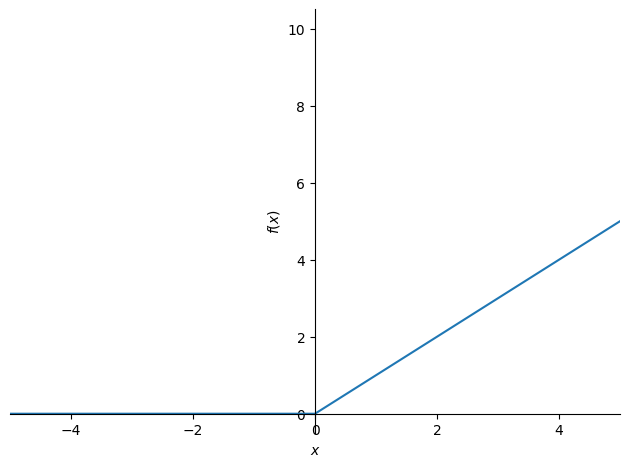

In [1201]:
# графическое представление функции активации ReLU
import sympy
sympy.plot("max(0,x)", xlim=(-5,5));

Наконец, теперь, когда у нас есть более одного набора коэффициентов, нам нужно добавить цикл для обновления каждого из них и обучения:

In [1202]:
# функция обновления коэффициентов по результату вычисления ошибки, ранее выглядела так:
# def update_coeffs(coeffs, lr):
#     coeffs.sub_(coeffs.grad * lr)
#     coeffs.grad.zero_()
# но тогда у нас не было слоев нейронной сети
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [1203]:
# вспоминаем как выглядит функция обучения модели
# def train_model(epochs=30, lr=0.01):
#     torch.manual_seed(442)
#     coeffs = init_coeffs()
#     for i in range(epochs):
#       one_epoch(coeffs, lr=lr)
#     return coeffs

coeffs = train_model(lr=100)

0.551; 0.381; 0.336; 0.238; 0.324; 0.216; 0.596; 0.554; 0.551; 0.354; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 0.219; 

In [1204]:
acc(coeffs)

tensor(0.8195)

Accuracy (Точность) такая же, как и ожидалось.

# **Deep learning или Глубокое обучение**


---


Нейронная сеть из предыдущего раздела использует только один скрытый слой, поэтому она не считается «глубоким» обучением. Но мы можем использовать ту же самую технику, чтобы сделать нашу нейронную сеть более глубокой, добавив больше матричных умножений.

Во-первых, нам нужно создать дополнительные коэффициенты для каждого слоя:

In [1208]:
def init_coeffs():
    hiddens = [10, 10]                # <-- установите размер каждого скрытого слоя, который вы хотите
    sizes = [n_coeff] + hiddens + [1] # --> [11, 10, 10, 1]
    n = len(sizes)                    # --> 4
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

You'll notice here that there's a lot magic **constants** to get the random numbers in just the right ranges... When you train the model in a moment, you'll see that the tiniest changes to these initialisations can cause our model to fail to train at all! This is a key reason that deep learning failed to make much progress in the early days -- it's very finicky to get a good starting point for our coefficients.

Our deep learning calc_preds looks much the same as before, but now we loop through each layer, instead of listing them separately:

Здесь вы заметите, что существует множество магических констант для получения случайных чисел в нужных диапазонах... Когда вы сразу обучите модель, вы увидите, что малейшие изменения в этих инициализациях могут привести к отказу нашей модели вообще тренироваться! Это основная причина того, что глубокое обучение не смогло добиться большого прогресса на первых порах — очень сложно получить хорошую отправную точку для наших коэффициентов.

Наше глубокое обучение Calc_preds выглядит почти так же, как и раньше, но теперь мы просматриваем каждый уровень, а не перечисляем их отдельно:

In [1209]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

Нам также нужно небольшое обновление update_coeffs, поскольку теперь у нас есть разделение слоев и констант:

In [1210]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

coeffs = train_model(lr=100)
acc(coeffs)

0.545; 0.390; 0.384; 0.384; 0.384; 0.384; 0.384; 0.384; 0.384; 0.383; 0.383; 0.382; 0.382; 0.380; 0.377; 0.369; 0.327; 0.200; 0.196; 0.195; 0.195; 0.194; 0.194; 0.194; 0.194; 0.194; 0.193; 0.193; 0.193; 0.193; 

tensor(0.8346)

Последние мысли автора (не мои)

На самом деле очень здорово, что нам удалось создать настоящую модель глубокого обучения с нуля и обучить ее, чтобы обеспечить точность выполнения этой задачи более 80 %, и все это в рамках одного блокнота!

«Настоящие» модели глубокого обучения, которые используются в исследованиях и промышленности, очень похожи на эту, и на самом деле, если вы заглянете в исходный код любой модели глубокого обучения, вы увидите, что основные шаги одинаковы.

Самые большие отличия практических моделей от приведенных выше:

Как выполняется инициализация и нормализация, чтобы обеспечить правильное обучение модели каждый раз. Регуляризация (чтобы избежать чрезмерной подгонки). Изменение самой нейронной сети, чтобы использовать преимущества знания проблемной области. Выполнение шагов градиентного спуска на меньших пакетах, а не на всем наборе данных. Я добавлю записные книжки обо всем этом позже и добавлю сюда ссылки, как только они будут готовы.# **Final thoughts**
